In [ ]:
import copy # copy variables
import os   # manage paths

import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import atlasopenmagic as atom

from src.parse_atlas import (parser, consts, schemas)

import traceback
%load_ext autoreload
%autoreload 2

In [ ]:
atlasparser = parser.ATLAS_Parser(release_year='')

In [40]:
mc_rec_id = atlasparser.fetch_mc_files_ids('2024', is_random=True)
all_metadata = atom.get_metadata(mc_rec_id)
urls = atom.get_urls(mc_rec_id)
atlasparser.parse_all_files(schemas.GENERIC_SCHEMA, files_ids=urls)

INFO:root:Processing 3 files
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191217._000011.pool.root.1


tt+photon MadGraphPythia8EvtGen_A14NNPDF23_ttgamma_nonallhadronic
tt+photon MadGraphPythia8EvtGen_A14NNPDF23_ttgamma_nonallhadronic


INFO:root:Parsing AnalysisElectrons with fields: ['pt', 'eta', 'phi', 'm', 'charge']
INFO:root:Parsing AnalysisMuons with fields: ['pt', 'eta', 'phi', 'charge']
INFO:root:Parsing AnalysisJets with fields: ['pt', 'eta', 'phi', 'm']
INFO:root:Finished, file number 1
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191217._000012.pool.root.1
INFO:root:Parsing AnalysisElectrons with fields: ['pt', 'eta', 'phi', 'm', 'charge']
INFO:root:Parsing AnalysisMuons with fields: ['pt', 'eta', 'phi', 'charge']
INFO:root:Parsing AnalysisJets with fields: ['pt', 'eta', 'phi', 'm']
INFO:root:Finished, file number 2
INFO:root:Processing file - root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.38191217._000013.pool.root.1
INFO:root:Parsing AnalysisElectrons with fields: ['pt', 'eta', 'phi', 'm', 'charge']
INFO:root:Parsing AnalysisMuons with fields: ['pt', 'eta', 'phi', 'charge']
INFO:root:Parsing AnalysisJets with fields:

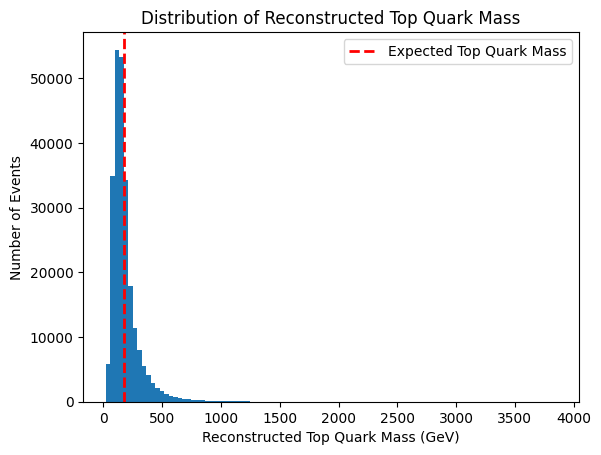

Total events: 490000
Events after filtering: 242629


In [41]:
GeV = 1000.

def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 10 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 10 * GeV) & (abs(j.eta) < 2.47)]

def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

def processed(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
    ]
    return ak.to_packed(events)

events = processed(atlasparser.events)
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(atlasparser.events))
print('Events after filtering:', len(events))

In [43]:
def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def electron_posi_muon_antimuon(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Electrons", "is_neg"] = events.Electrons.charge < 0
    events["Muons", "is_neg"] = events.Muons.charge < 0
    events = events[
        (ak.num(events.Electrons) == 2) 
        & (ak.num(events.Muons) == 2)
        # & (ak.num(events.Electrons[events.Electrons.is_neg]) == 1)
        # & (ak.num(events.Muons[events.Muons.is_neg]) == 1)
    ]
    return ak.to_packed(events)

events = electron_posi_muon_antimuon(atlasparser.events)
plt.hist(ak.flatten(events) / GeV, axis=None, bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(atlasparser.events))
print('Events after filtering:', len(events))

ValueError: arrays of records cannot be flattened (but their contents can be; try a different 'axis')